
# Recommendation System Trilogy (推荐系统三部曲)


## Project Description
Which movie should I watch today? There are so many choices that I have to consult my friends. However, my friends are struggling with the exactly same question. So here is the recommendation system to predict what my perference is. In this project, I implement three popular approaches: content-based, user-based and matrix factorization. The final goal is to examine, compare and combine them to make recommendation system more powerful.


## Procedure
* [Matrix factorization](#step-1)
* [Content-based prediction](#step-2)
* [Collaborative filtering](#step-3)
* [Combinations](#step-4)
* [Epilogue](#step-5)


## Part 0: Imports



In [21]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper', 'fivethirtyeight', 'seaborn-whitegrid'])
import seaborn as sns

import datetime as dt
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


<a id="step-1"></a>
## Part 1: Matrix factorization

First we'll look in detail at one popular implementation of matrix factorization. It is the alternating least squares algorithm.
We will assume that the input data is the forms of (a, i, r) triples, where a is a user index. i is an item index and r is a rating. Here is a small example:
[(0, 0, 5), (0, 1, 3), (0, 3, 1),
 (1, 0, 4), (1, 3, 1), 
 (2, 0, 1), (2, 1, 1), (2, 3, 5), 
 (3, 0, 1), (3, 3, 4), 
 (4, 1, 1), (4, 2, 5), (4, 3, 4)].
 




### 1) Roadmap
 The overall plan for als function is following:
* Define n and m from the data.
* Initialize a list of lists that indicates for each item the indices of users that rate that item and vice versa.
* Initialize the set of parameters, note that the u,v entries are set randomly while the user and item offsets are set to 0.
* Then we alternate minimizations.(update_U, update_V)
* And, report the results, the error between predicted scores and a held-out set of actual scores on the same users and items.

Let us first define ridge regression.

In [58]:
def ridge_analytic(X,Y,lam):
    n, d = X.shape
    th = np.linalg.solve(X.T @ X + lam* np.identity(d), X.T @ Y)
    return th

In [59]:
def update_U(data, us_from_v, x, k, lam):
    u, v = x
    idx_list = [[t[0] for t in user] for user in us_from_v]
    rating_list = [[t[1] for t in user] for user in us_from_v]
    
    for i in range(len(u)):
        idx_movie = idx_list[i]
        rating = rating_list[i]    
        X = np.vstack([np.reshape(v[j], (1,k)) for j in idx_movie])
        y = rating
        
        u[i] = ridge_analytic(X,y,lam)
    x = u, v

    return x

In [60]:
def update_V(data, vs_from_u, x, k, lam):
    u, v = x
    idx_list = [[t[0] for t in m] for m in vs_from_u]
    rating_list = [[t[1] for t in m] for m in vs_from_u]

    for i in range(len(v)):
        idx_user = idx_list[i]
        rating = rating_list[i]               
   
        X = np.vstack([np.reshape(u[j], (1,k)) for j in idx_user])
        y = rating
        v[i] = ridge_analytic(X,y,lam)
    x = u, v
#     print(x)
    return x

In [72]:
def retrive_rating(x, a, i):
    U = x[0]
    V = x[1]
    rating = np.inner(U[a-1], V[i-1])
    return rating

In [62]:
def rmse(x, us_from_v, lam):
    ans = 0
    
    # square loss
    all_error = 0
    for u_id in range(len(us_from_v)):
        for t in us_from_v[u_id]:
            m_id = t[0]
            m_rating = t[1]
            
            pred_rating = retrive_rating(x, u_id, m_id)
            error = (m_rating-pred_rating)**2
            all_error = all_error + error
    
    # regulazation terms
    u = len(x[0])
    m = len(x[1])
    k = len(x[0][0])
    U = np.reshape(np.array(x[0]), (u,k))
    V = np.reshape(np.array(x[1]), (m,k))
    penality_U = np.sum(U**2) * lam
    penality_V = np.sum(V**2) * lam
    
    # add all
    ans = all_error + penality_U + penality_V
    
    return np.sqrt(ans)

In [63]:
def als(data, k=2, lam=0.02, max_iter=10):
    """input: data is list of (userId, movieId, ratings),
        k is the rank of approximation matrix,
        lam is regulazation parameter,
        
        output: the estimated matrix: U@V.
        """
    # minimum id = 1, transform to 0
    min_id = min([t[0] for t in data])
    if min_id == 1:
        for i in range(len(data)):
            data[i] = (data[i][0]-1, data[i][1]-1, data[i][2])
    # data size
    u = max([t[0] for t in data]) + 1 # useId
    m = max([t[1] for t in data]) + 1 # movieId
    
    # entries put in [[user_1], [user_2],...], where user_1 = (rating moive one, rating movie two, ...)
    us_from_v = [[] for i in range(u)]
    vs_from_u = [[] for i in range(m)]
    for (a, i, r) in data:
        us_from_v[a].append((i, r))
        vs_from_u[i].append((a, r))
    # initialize guess of vs
    x = ([np.random.normal(1, size=(k,1)) for a in range(u)], \
         [np.random.normal(1, size=(k,1)) for i in range(m)])
    
    rmse_list = []
    for i in range(max_iter):
#         print('iter time: %i' %i)
        # update u_i
#         print('update U -----------------------------------------')
        x = update_U(data, us_from_v, x, k, lam)
        # update v_j
#         print('update V -----------------------------------------')
        x = update_V(data, vs_from_u, x, k, lam)
        
        # report rmse
        rmse_ = rmse(x, us_from_v, lam)
        rmse_list.append(rmse_)
        print('root mean square error: %f' %rmse_)
    print('final rmse: %f' %rmse_)
    return x, rmse_list

    
    
    

### 2)  Test for fake data.


In [21]:
data = \
[(0, 0, 5), (0, 1, 3), (0, 3, 1),
 (1, 0, 4), (1, 3, 1), 
 (2, 0, 1), (2, 1, 1), (2, 3, 5), 
 (3, 0, 1), (3, 3, 4), 
 (4, 1, 1), (4, 2, 5), (4, 3, 4)]

In [22]:
x,_ = als(data)

root mean square error: 4.953003
root mean square error: 3.020629
root mean square error: 2.385033
root mean square error: 2.167921
root mean square error: 1.971934
root mean square error: 1.710318
root mean square error: 1.526481
root mean square error: 1.446399
root mean square error: 1.388472
root mean square error: 1.343768
final rmse: 1.343768


In [23]:
retrive_rating(x, 1, 1)

2.3865046032072184

### 3) Test real dataset
We use rating and movie dataframe from movieLen-100k dataset.

In [22]:
ratings = pd.read_csv('ml-100k/u.data', delimiter = '\t', header=None)
ratings.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [23]:
ratings.columns = ['userId', 'movieId', 'rates', 'timestamp']
ratings = ratings.drop(['timestamp'], axis = 1)
ratings.head()

,userId,movieId,rates
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [12]:
u_num = len(ratings['userId'].unique())
m_num = len(ratings['movieId'].unique())
print('sparse matrix has shape:', (m_num, u_num))

sparse matrix has shape: (1682, 943)


In [64]:
m_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url','unknown', 
          'Action', 'Adventure','Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy','Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
          'Thriller', 'War', 'Western']
movie = pd.read_csv('ml-100k/u.item', delimiter = '\|', header=None)
movie.columns = m_cols
movie.head()

G:\anaconda_3\lib\site-packages\ipykernel_launcher.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """


,movieId,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
data = [tuple(i) for i in list(ratings.values)]

In [66]:
x, _ = als(data, k = 5)

root mean square error: 290.618351
root mean square error: 270.447402
root mean square error: 264.323823
root mean square error: 260.138352
root mean square error: 257.293977
root mean square error: 255.424727
root mean square error: 254.204173
root mean square error: 253.374690
root mean square error: 252.744862
root mean square error: 252.239281
final rmse: 252.239281


In [27]:
retrive_rating(x, 1, 1)

3.392715439412202

### 4)  Cross validation for  k

try k = 10 ----------------------------------------------
root mean square error: 271.857806
root mean square error: 245.382827
root mean square error: 236.333706
root mean square error: 231.853048
root mean square error: 229.143946
root mean square error: 227.244577
root mean square error: 225.833639
root mean square error: 224.747006
root mean square error: 223.871580
root mean square error: 223.137944
final rmse: 223.137944
try k = 50 ----------------------------------------------
root mean square error: 188.546738
root mean square error: 149.526078
root mean square error: 133.489798
root mean square error: 124.210816
root mean square error: 117.920156
root mean square error: 113.283244
root mean square error: 109.693646
root mean square error: 106.822484
root mean square error: 104.463184
root mean square error: 102.477221
final rmse: 102.477221
try k = 100 ----------------------------------------------
root mean square error: 126.428776
root mean square error: 89.257111
root mean 

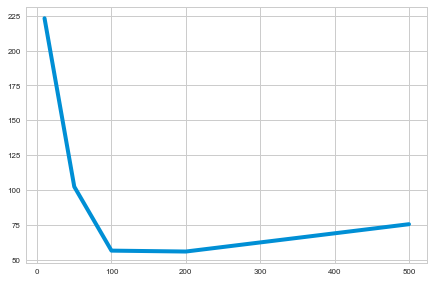

In [191]:
k_range = [10, 50, 100, 200, 500]

err_list = [] # collect final rmse for each k
for k in k_range:
    print('try k = %i ----------------------------------------------' %k)
    x, rmse_list = als(data, k, lam=0.02, max_iter=10)
    final_rmse = rmse_list[-1]
    
    err_list.append(final_rmse)
idx = np.argmin(err_list)
best_k = k_range[idx]

    
plt.plot(k_range, err_list)

This plot is quite similar with theory, before k = 100, loss is reducing rapidly, but after that comes overfitting. Here we choose k = 100.We redo the training precess and get best U and V.

In [67]:
x, _ = als(data, k = 100, lam=0.02, max_iter=100)

root mean square error: 125.332104
root mean square error: 88.931243
root mean square error: 76.016976
root mean square error: 69.331140
root mean square error: 65.183496
root mean square error: 62.308760
root mean square error: 60.158580
root mean square error: 58.464429
root mean square error: 57.077493
root mean square error: 55.909262
root mean square error: 54.903901
root mean square error: 54.023789
root mean square error: 53.242480
root mean square error: 52.540750
root mean square error: 51.904157
root mean square error: 51.321715
root mean square error: 50.784944
root mean square error: 50.287173
root mean square error: 49.823069
root mean square error: 49.388313
root mean square error: 48.979365
root mean square error: 48.593297
root mean square error: 48.227664
root mean square error: 47.880408
root mean square error: 47.549780
root mean square error: 47.234275
root mean square error: 46.932587
root mean square error: 46.643576
root mean square error: 46.366237
root mean squ

### 5)  For user 1, she's interests:

In [70]:
range(1, m_num+1)

range(1, 1683)

In [73]:
total_movies= []

for m in range(1, m_num+1):
    rates = retrive_rating(x, 1, m)
    my_movies = {}
    my_movies['movieId'] = m
    my_movies['rates'] = rates
    
    total_movies.append(my_movies)



In [74]:
total_movies = pd.DataFrame(total_movies)
total_movies.head()

,movieId,rates
0,1,5.001907
1,2,2.983923
2,3,3.997448
3,4,2.998442
4,5,2.996689


In [75]:
total_movies.sort_values('rates', ascending=False, inplace=True)
total_movies.head(10)

,movieId,rates
381,382,6.556119
548,549,6.322914
284,285,6.232259
510,511,6.072598
918,919,6.041103
282,283,5.927190
293,294,5.911026
649,650,5.806335
1100,1101,5.799419
1038,1039,5.785735


In [107]:
joined = pd.merge(total_movies[0:21], movie, how='inner', on = ['movieId'])
joined['title']

0     Adventures of Priscilla, Queen of the Desert, ...
1                                        Rob Roy (1995)
2                                 Secrets & Lies (1996)
3                             Lawrence of Arabia (1962)
4                     City of Lost Children, The (1995)
5                                           Emma (1996)
6                                      Liar Liar (1997)
7       Seventh Seal, The (Sjunde inseglet, Det) (1957)
8                      Six Degrees of Separation (1993)
9                                         Hamlet (1996)
10                                       Othello (1995)
11                                   Wag the Dog (1997)
12                             L.A. Confidential (1997)
13                     In the Name of the Father (1993)
14          Mrs. Brown (Her Majesty, Mrs. Brown) (1997)
15                                 All About Eve (1950)
16                         To Kill a Mockingbird (1962)
17                Day the Earth Stood Still, The

<a id="step-2"></a>
## Part 2  Content-based prediction
This is a standard machine learning problem: for one particular user, we would like to predict her ratings on movies she haven't watched, based on her rating history.
One main focus is extract appropriate movie features such as genres, duration time and Directors. In our moiveLen dataset, we only have genres to make prediction. For simplicity, we only focus on user_1.

## 1) Clean data

In [84]:
print('shape of movie data: ',movie.shape)
movie.columns

shape of movie data:  (1682, 24)


Index(['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url',
       'unknown', 'Action', 'Adventure', 'Animation', 'Children's', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'],
      dtype='object')

In [85]:
movie.head()

,movieId,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [86]:
ratings_1 = ratings[ratings['userId'] == 1].copy()
print(ratings_1.shape)
ratings_1.head()

(272, 3)


,userId,movieId,rates
202,1,61,4
305,1,189,3
333,1,33,4
334,1,160,4
478,1,20,4


In [87]:
movie_train = pd.merge(ratings_1, movie, how='inner', on=['movieId'])
movie_train.head()


,userId,movieId,rates,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,61,4,Three Colors: White (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,189,3,"Grand Day Out, A (1992)",01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Grand%20Day%2...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,33,4,Desperado (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Desperado%20(...,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,1,160,4,Glengarry Glen Ross (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Glengarry%20G...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,20,4,Angels and Insects (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Angels%20and%...,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [88]:
idx = movie['movieId'].apply(lambda x: x not in movie_train['movieId'])
movie_pred = movie[idx]
print(movie_pred.shape)
movie_pred.head()

(1411, 24)


,movieId,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
271,272,Good Will Hunting (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,273,Heat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Heat%20(1995),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
273,274,Sabrina (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Sabrina%20(1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
274,275,Sense and Sensibility (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Sense%20and%2...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
275,276,Leaving Las Vegas (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Leaving%20Las...,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Explore use_1's perference, look at the distribution of her rates.

In [89]:
movie_train.columns

Index(['userId', 'movieId', 'rates', 'title', 'release_date',
       'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

(array([25.,  0., 28.,  0.,  0., 56.,  0., 82.,  0., 81.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

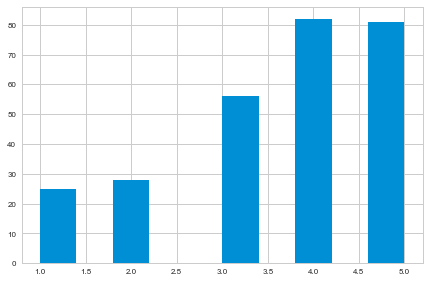

In [90]:
plt.hist(movie_train['rates'])

The infomation from above plot is subtle, she seems to rate high, most movies she has watched is rated above 2. 

## 2) (Attemp to) add features
we want incorpate release date. 

In [104]:
import datetime as dt

movie_train['release_date'] = pd.to_datetime(movie_train['release_date'])

movie_train['year'] = movie_train['release_date'].apply(lambda x: x.year)
movie_train['month'] = movie_train['release_date'].apply(lambda x: x.month)
movie_train['date'] = movie_train['release_date'].apply(lambda x: x.day)


In [105]:
movie_train = movie_train[movie_train['year'].notnull()]

Check features using scatter plot.

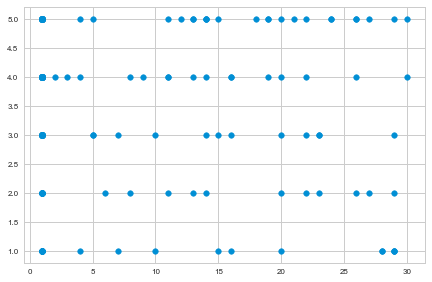

In [106]:
plt.scatter(movie_train['date'], movie_train['rates'])

It tends out that these date features are useless.

## 3) Logistic regression 
First trial is easy linear model: logistic regression. Here we label data with conditon: rates == 5.Notice that  other groupings like rates > 3, can't serve for recommendation purpose,and they also make predictions bad.

We split data into train, validation and test sets. 

In [93]:
def cv_optimize(clf, param, X_train, y_train, n_folds=5):
    gs = GridSearchCV(clf, param_grid=param, cv = n_folds)
    gs.fit(X_train, y_train)
    best_param = gs.best_params_
    best_clf = gs.best_estimator_
    
    return best_clf, best_param

In [91]:
movie_train.columns

Index(['userId', 'movieId', 'rates', 'title', 'release_date',
       'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [94]:
X = movie_train.iloc[:,7:]
y = movie_train['rates'] == 5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = LogisticRegression()

param = {'C':[0.001, 0.01, 0.1, 1, 10]}
best_clf,_ = cv_optimize(clf, param, X_train, y_train, n_folds=10)

best_clf

G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-pa

G:\anaconda_3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [95]:
best_clf.fit(X_test, y_test)
best_clf.score(X_test, y_test)


G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6707317073170732

## 4) Diagnose: under fitting or over fitting?

In [179]:
def do_classify(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    clf.fit(X_train, y_train)
    s_train = clf.score(X_train, y_train)
    s_test = clf.score(X_test, y_test)
    
    return s_train, s_test

In [180]:
def diagnose_plot(clf, X, y):
    n, p = X.shape
    training_accu = []
    testing_accu = []
    for i in range(10, n, 6):
        X_ = X.iloc[:i, :]
        y_ = y[:i]
        s_train, s_test = do_classify(clf, X_, y_)
        training_accu.append(s_train)
        testing_accu.append(s_test)

    plt.plot(range(10, n, 6), 1-np.array(training_accu))
    plt.plot(range(10, n, 6), 1-np.array(testing_accu))
    plt.legend(['train', 'test'])
    plt.show()
    


G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
G:\anaconda_3\lib\site-pa

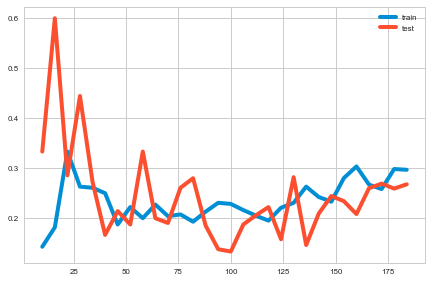

In [181]:
diagnose_plot(LogisticRegression(), X_train, y_train)

## 5) High bias, try nonlinear model: random forest

In [182]:
def cv_optimize(clf, param, X_train, y_train, n_folds=5):
    gs = GridSearchCV(clf, param_grid=param, cv = n_folds)
    gs.fit(X_train, y_train)
    best_param = gs.best_params_
    best_clf = gs.best_estimator_
    
    return best_clf, best_param

In [96]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
param = {"n_estimators": range(1, 20)}
best_clf, best_param = cv_optimize(clf, param, X, y, n_folds=10)

print((best_clf, best_param))
# diagnose_plot(best_clf, X, y)



(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), {'n_estimators': 13})


G:\anaconda_3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


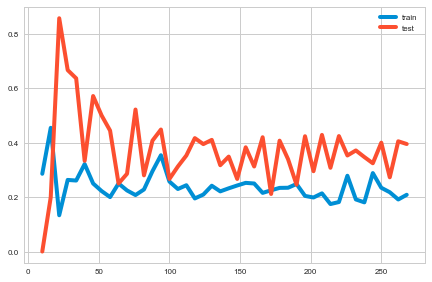

0.7804878048780488


In [184]:
diagnose_plot(best_clf, X, y)
best_clf.fit(X_test, y_test)
print(best_clf.score(X_test, y_test))

## 6) Make predictions
Based on random forest classifier, we predict highly rated movies that user_1 haven't watched.
[recom_movies] data frame contains all the recommendations.


In [97]:
X_pred = movie_pred.iloc[:,5:]
X_pred.head()

,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
271,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
272,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
273,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
274,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
275,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [98]:
movie_pred.shape

(1411, 24)

In [99]:
recom = best_clf.predict(X_pred)
movie_pred[recom].shape

(137, 24)

In [100]:
recom_movie_id = movie_pred[recom]['movieId']
recom_movie_id.head()

297    298
301    302
311    312
312    313
319    320
Name: movieId, dtype: int64

In [101]:
recom_movies = movie_pred[recom]['title']
print('total number of recommend movies:%i' %len(recom_movies))
recom_movies.head()

total number of recommend movies:137


297                                      Face/Off (1997)
301                             L.A. Confidential (1997)
311       Midnight in the Garden of Good and Evil (1997)
312                                       Titanic (1997)
319    Paradise Lost: The Child Murders at Robin Hood...
Name: title, dtype: object

<a id="step-3"></a>
## Part 3: Collaborative filtering

In [33]:
def get_similarity(us_from_v, user_id):
    """output:
        a pd dataframe with columns: userId,simiarity score"""
    
    ans = []
    # data size
    u = len(us_from_v) # useId
    
    # this user watched movies
#     print(us_from_v)
    me_watched = pd.DataFrame(us_from_v[user_id])
#     print(me_watched)
    me_watched.columns = ['movieId', 'me_ratings']
    for i in range(u):
        # find overlapping movies, ratings
        i_watched = pd.DataFrame(us_from_v[i])
        i_watched.columns = ['movieId', 'i_ratings']
        overlap = pd.merge(me_watched, i_watched, how='inner', on=['movieId'])
             
        # computer similarity        
        o_center = overlap.apply(lambda x: x - overlap.mean(axis = 0), axis = 1)
        me_col = o_center['me_ratings']
        i_col = o_center['i_ratings']
        sim = np.sum(me_col*i_col)/np.sqrt(np.sum(me_col**2) * np.sum(i_col**2))
        
        # collect data
        ans_i = {'userId':i, 'sim': sim}
        ans.append(ans_i)
        
    # sort data by abs(similarity)
    ans_df = pd.DataFrame(ans)
    
    ans_df['abs_sim'] = ans_df['sim'].abs()
    ans_df.sort_values(['abs_sim'], ascending=False, inplace=True)
    ans_df.drop(['abs_sim'], axis = 1, inplace=True)
  

    return ans_df
    

In [34]:
def check_watched(movieId, userId, us_from_v):
    # convert data to dictionary: 
    # {1: {1: 2, 3: 1}, 2: {1: 1, 3: 5}}
    d = {}
    for i in range(len(us_from_v)):
        d_inner = {}
        for t in us_from_v[i]:
            d_inner[t[0]] = t[1]
        d[i] = d_inner 
        
    # check if in
    if movieId in d[userId]:
        rating = d[userId][movieId]
        return (True, rating)
    else:
        return (False, 0)
    
    

In [35]:
def get_watched(us_from_v, movieId, sim_group, sim_num):
    """return:
        dataframe with columns:['userId', 'sim', 'ave_ratings']"""
    
    # initialize ans
    watched = pd.DataFrame(columns=['userId', 'sim', 'ave_ratings'])
    count = 0
    
    # each user check if she watched this movie 
    for i in range(len(sim_group)):
        #print('------------')
        userId = sim_group.loc[i, 'userId']
        #print('i,userId:',i, userId)
        
        while check_watched(movieId, userId, us_from_v)[0] and count < sim_num+1:
            # get ['userId', 'sim', 'ave_ratings']
            watched.loc[count] = sim_group.loc[i]
            # get that rating
            watched.loc[count, 'movie_rating'] = check_watched(movieId, userId, us_from_v)[1]
            count = count + 1
            
            #print(watched)
            
    return watched
    

In [36]:
def convertData(data):
    # minimum id = 1, transform to 0
    min_id = min([t[0] for t in data])
    if min_id == 1:
        for i in range(len(data)):
            data[i] = (data[i][0]-1, data[i][1]-1, data[i][2])
    # convert data
    u = max([t[0] for t in data]) + 1 # useId
    us_from_v = [[] for i in range(u)]
    for (a, i, r) in data:
        us_from_v[a].append((i, r))
        
    return us_from_v

In [37]:
# for one user a, predict rating in movie i
def predict(us_from_v, user_id, movieId, sim_num=5):
#     # convert Data
#     us_from_v = convertData(data)
    
    # get similar people
    sim_group = get_similarity(us_from_v, user_id)
    
    # add average ratings for each user
    ave_ratings = [np.mean([t[1] for t in u]) for u in us_from_v]
    sim_group['ave_ratings'] = ave_ratings
        
    # get people who watched this movie
    watched_group = get_watched(us_from_v, movieId, sim_group, sim_num)
    
    # calculate scores
    weights = watched_group['sim']
    y_i = watched_group['movie_rating']
    ybar = watched_group['ave_ratings']
    deviation = np.sum((y_i - ybar) * weights) / weights.sum()
    
    # get this user's average rating
    rating_list = [t[1] for t in us_from_v[user_id]]
    user_average = np.mean(rating_list)
    
    pred_rating = user_average + deviation    
    return pred_rating

## 2) Test fake data

In [29]:
data = \
[(0, 0, 5), (0, 1, 3), (0, 3, 1),
 (1, 0, 4), (1, 3, 1), 
 (2, 0, 1), (2, 1, 1), (2, 3, 5), 
 (3, 0, 1), (3, 3, 4), 
 (4, 1, 1), (4, 2, 5), (4, 3, 4)]

us_from_v = convertData(data)
predict(us_from_v, 1, 2, sim_num=2)

G:\anaconda_3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
G:\anaconda_3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


nan

## 3) Real dataset predictions
We focus on user_1 to compare with previous methods.

In [39]:
ratings = pd.read_csv('ml-100k/u.data', delimiter = '\t', header=None)
ratings.columns = ['userId', 'movieId', 'rates', 'timestamp']
ratings = ratings.drop(['timestamp'], axis = 1)
ratings.head()



,userId,movieId,rates
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [38]:
data = [tuple(i) for i in list(ratings.values)]
us_from_v = convertData(data)
predict(us_from_v, 1, 100, sim_num=5)

G:\anaconda_3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
G:\anaconda_3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


2.0511408339889847

In [55]:
def pred_rating_user(us_from_v, userId, m_num):
    rating_user_ = []
    for m_id in range(1, m_num+1):
        # check if watched
        check_, r = check_watched(m_id, userId, us_from_v)
        if check_:
            rating_user_.append(r)
        else:
            # calculate predicted ratings
            r = predict(us_from_v, userId, m_id, sim_num=8)
            rating_user_.append(r)
        print('for movie %i, predicted rating is %f' %(m_id, r))
    return rating_user_


In [56]:
u_num = len(ratings['userId'].unique())
m_num = len(ratings['movieId'].unique())
print('sparse matrix has shape:', (m_num, u_num))

pred_rating_user(us_from_v, 1, m_num)

sparse matrix has shape: (1682, 943)


G:\anaconda_3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
G:\anaconda_3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


for movie 1, predicted rating is 3.051141
for movie 2, predicted rating is 4.051141
for movie 3, predicted rating is 3.051141


KeyboardInterrupt: 

<a id="step-4"></a>
## Combinations
We combine these methods implemented above, to get intersection of recommendations.

In [130]:
joined = pd.merge(total_movies, movie_pred, how='inner', on = ['movieId'])
joined.head()

,movieId,rates,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,382,6.556119,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,549,6.322914,Rob Roy (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Rob%20Roy%20(...,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,285,6.232259,Secrets & Lies (1996),04-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Secrets%20&%2...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,511,6.072598,Lawrence of Arabia (1962),01-Jan-1962,NaN,http://us.imdb.com/M/title-exact?Lawrence%20of...,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,919,6.041103,"City of Lost Children, The (1995)",01-Jan-1995,NaN,http://us.imdb.com/Title?Cit%E9+des+enfants+pe...,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [131]:
method_1 = joined['movieId']
method_1.head(10)

0     382
1     549
2     285
3     511
4     919
5     283
6     294
7     650
8    1101
9    1039
Name: movieId, dtype: int64

In [132]:
recom_movie_id.head(10)

297    298
301    302
311    312
312    313
319    320
326    327
355    356
358    359
359    360
384    385
Name: movieId, dtype: int64

In [145]:
final_recom = []
count = 0
rejected = 0

for i in method_1:
    print(i)
    if i in recom_movie_id and count < 11:
        final_recom.append(i)
        count = count + 1
        print(final_recom)
    else:
        rejected = rejected + 1

# print('recommendation movieId:',final_recom)
# print('rejected by cntent-based method:', rejected)

382
549
285
511
[511]
919
283
294
650
1101
1039
713
347
302
317
306
606
427
429
509
403
333
421
[511, 421]
715
340
291
505
513
303
343
423
632
478
325
736
367
792
277
1065
1119
286
642
435
647
480
661
499
323
408
655
[511, 421, 655]
529
483
[511, 421, 655, 483]
282
625
740
311
[511, 421, 655, 483, 311]
1110
498
425
519
512
1011
963
528
473
708
489
615
659
651
305
1014
521
358
[511, 421, 655, 483, 311, 358]
332
274
755
735
694
781
699
641
923
589
531
596
477
939
517
945
523
527
882
660
806
628
327
482
739
789
455
1142
474
357
646
322
275
729
1115
481
1073
689
582
561
510
559
420
451
654
380
331
844
465
[511, 421, 655, 483, 311, 358, 465]
298
663
476
900
709
504
1063
354
387
847
[511, 421, 655, 483, 311, 358, 465, 847]
633
[511, 421, 655, 483, 311, 358, 465, 847, 633]
577
381
313
705
922
744
771
856
[511, 421, 655, 483, 311, 358, 465, 847, 633, 856]
820
289
479
1005
[511, 421, 655, 483, 311, 358, 465, 847, 633, 856, 1005]
418
507
956
969
430
493
686
344
432
613
558
879
419
315
396
304
48

In [142]:
idx = joined['movieId'].apply(lambda x: x in final_recom)
joined[idx][['rates','title']]

,rates,title
3,6.072598,Lawrence of Arabia (1962)
21,5.317573,William Shakespeare's Romeo and Juliet (1996)
48,4.670937,Stand by Me (1986)
50,4.631683,Casablanca (1942)
54,4.563235,"Wings of the Dove, The (1997)"
72,4.310591,Spawn (1997)
121,3.910539,"Jungle Book, The (1994)"
131,3.857628,Looking for Richard (1996)
132,3.841147,"Christmas Carol, A (1938)"
140,3.735119,Night on Earth (1991)


<a id="step-5"></a>
## Epilogue

Recommendations based on different methods tends to have different outcomes, we intersect outcomes of matrix factorization and random forest, and select top 20, as is shown above. 
My implementation of Collaorative filtering is surprisingly slow, further examination of computational complexity is needed, Also, this result needs to be put into real world context to check its strength and weakness.